## Цель работы

1. Создать примеры моделей нейронных сетей для классификации изображений 
2. Попробовать обучить модель нейронной сети на малом количестве данных
3. Сделать выводы по обученным моделям

In [1]:
import pandas as pd # Для работы с датафреймом
import os # Для работы с файлами
import shutil # Для работы с файлами
from PIL import Image # Для работы с фотографиями
import numpy as np # Для работы с массивами
import matplotlib.pyplot as plt # Для отрисовки графиков

# Для работы с нейронными сетями через библиотеку Keras
import keras as kr
from keras.layers import Dense, Flatten

# Для работы с нейронными сетями через библиотеку PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets 
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision

C:\Users\denis\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Изучим группу, делавшую фотографии

In [2]:
# Загружаем данные
df = pd.read_csv('emotions.csv')

In [3]:
df.tail()

,set_id,gender,age,country
14,14,FEMALE,20,RU
15,15,FEMALE,18,RU
16,16,FEMALE,37,RU
17,17,FEMALE,24,RU
18,18,MALE,19,RU


Всего 19 человек

In [4]:
print(r'Женщин: {}  Мужчин: {}'.format(len(df[df['gender']=="FEMALE"]),len(df[df['gender']=="MALE"])))

Женщин: 14  Мужчин: 5


In [5]:
print("Количество стран:", len(df["country"].unique()))
for i in df["country"].unique():
    print(r"Людей из страны с сокращением {} : {}".format(i, len(df[df['country']==i])))

Количество стран: 3
Людей из страны с сокращением RU : 17
Людей из страны с сокращением PH : 1
Людей из страны с сокращением IN : 1


In [6]:
print("Возраст старшего участника: ", df["age"].max())
print("Возраст младшего участника: ", df["age"].min())
print("Средний возраст участников: ", df["age"].mean())
print("Количество несовершеннолетних участников", len(df[df["age"]<18]))

Возраст старшего участника:  49
Возраст младшего участника:  15
Средний возраст участников:  31.105263157894736
Количество несовершеннолетних участников 1


In [7]:
print("Средний возраст участников: ", df["age"][df["age"]>17].mean())

Средний возраст участников:  32.0


### Подготовка данных

In [8]:
# Проверям, все ли картинки имеют одинаковое разрешение и какое
min_width, min_height = 10000,10000
PHOTO_RESOLUTION = set()
for i in range(len(df)):
    for j in os.listdir(r'images/{}'.format(i)):
        width, height = Image.open(r'images\\{}\{}'.format(i,j)).size
        PHOTO_RESOLUTION.add((width, height))
        if width <= min_width:
            min_width, min_height = width, height
print("Количество раличных разрешений у фотографий: {} \nМинимальное разрешение: {}".format(len(PHOTO_RESOLUTION), (min_width, min_height)))  

Количество раличных разрешений у фотографий: 12 
Минимальное разрешение: (1280, 720)


Все фото имеют разные разрешения. Варианты решения проблемы:
1. Привессти все фотографии к одному виду
2. Использовать модели, для которых не важна однотипность данных

В качестве эксперимента, когда будем строить модель попробуем оба варианта

In [9]:
# Смотрим, какие есть классы фотографий
files=os.listdir('images/0')
emotions=[]
for f in  files:
    emotions.append(f[:-4])
print("Эмоции на фотографиях: ", ", ".join(emotions))

Эмоции на фотографиях:  Anger, Contempt, Disgust, Fear, Happy, Neutral, Sad, Surprised


In [10]:
# Вы можете игнорировать этот блок кода при повторном запуске проекта

# Создадим папку с фото, отсортированными по эмоциям
shutil.rmtree('emotions', ignore_errors = True) # Удаляет директорию, созданную ранее при работе кода
os.mkdir(r'emotions')
for emo in emotions:
    os.mkdir(r'emotions/{}'.format(emo))

In [11]:
# Скопируем фотографии в новые папки
for i in os.listdir('images')[1:]:
    for emo in emotions:
        shutil.copyfile(r'images\\{}\{}.jpg'.format(i,emo), r'emotions\{}\\{}.jpg'.format(emo,i))

In [12]:
# Создадим функцию для настройки датасета
def data(directory, batch_size, image_size, validation_split):
    # На функцию подается путь к директории, длина пакетов данных, разрешение фотографии, количество зарезервированных данных под проверку
    # Пример: 'emotions', 8, (351,351), 0.2
    global training_data 
    training_data= kr.preprocessing.image_dataset_from_directory( # Тренировочный набор данных
        directory,
        batch_size = batch_size,
        image_size = image_size,
        shuffle = True,
        seed =100,
        subset ='training',
        validation_split = validation_split)
    global validation_data 
    validation_data = kr.preprocessing.image_dataset_from_directory( # Валидационный набор данных
        directory,
        batch_size = batch_size,
        image_size = image_size,
        shuffle = True,
        seed =100,
        validation_split = validation_split,
        subset ='validation')

In [13]:
# Создадим функцию для визуализации обучения нейронной сети
def visualization(history_dict, epoch): 
    # Функция принимает на вход словарь с историей обучения, количество эпох обучения нейронной сети
    
    # Настройка графика ошибок на тренировочных и валидационных данных
    plt.figure(figsize=(16, 8))
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, epoch+1)
    plt.plot(epochs, loss_values, 'ro', label='Ошибка трен. данных')
    plt.plot(epochs, val_loss_values, 'r', label='Ошибка вал. данных') 
    plt.title('Тренировочные и валидационные данные. Ошибки')
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибки')
    plt.legend()
    plt.show()
    
    plt.clf() # Очистка рисунка
    
    # Настройка графика точности на тренировочных и валидационных данных
    plt.figure(figsize=(16, 8))
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, acc_values, 'go', label='Точность трен. данных')
    plt.plot(epochs, val_acc_values, 'g', label='Точность вал. данных')
    plt.title('Тренировочные и валидационные данные. Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

### Реализация нейронной сети через Keras

Found 152 files belonging to 8 classes.
Using 122 files for training.
Found 152 files belonging to 8 classes.
Using 30 files for validation.


Epoch 1/20
16/16 [==============================] - 10s 333ms/step - loss: 3.1275 - accuracy: 0.0820 - val_loss: 2.7285 - val_accuracy: 0.0667
Epoch 2/20
16/16 [==============================] - 5s 278ms/step - loss: 2.1049 - accuracy: 0.1311 - val_loss: 2.4389 - val_accuracy: 0.0333
Epoch 3/20
16/16 [==============================] - 6s 294ms/step - loss: 2.0026 - accuracy: 0.2049 - val_loss: 2.7560 - val_accuracy: 0.0333
Epoch 4/20
16/16 [==============================] - 5s 283ms/step - loss: 2.0221 - accuracy: 0.2213 - val_loss: 2.4947 - val_accuracy: 0.0333
Epoch 5/20
16/16 [==============================] - 6s 282ms/step - loss: 1.9370 - accuracy: 0.2459 - val_loss: 2.6901 - val_accuracy: 0.0667
Epoch 6/20
16/16 [==============================] - 7s 354ms/step - loss: 1.8973 - accuracy: 0.2459 - val_loss: 2.4816 - val_accuracy: 0.0000e+00
Epoch 7/20
16/16 [==============================] - 6s 290ms/step - loss: 1.8627 - accuracy: 0.2869 - val_loss: 2.5278 - val_accuracy: 0.0000e+

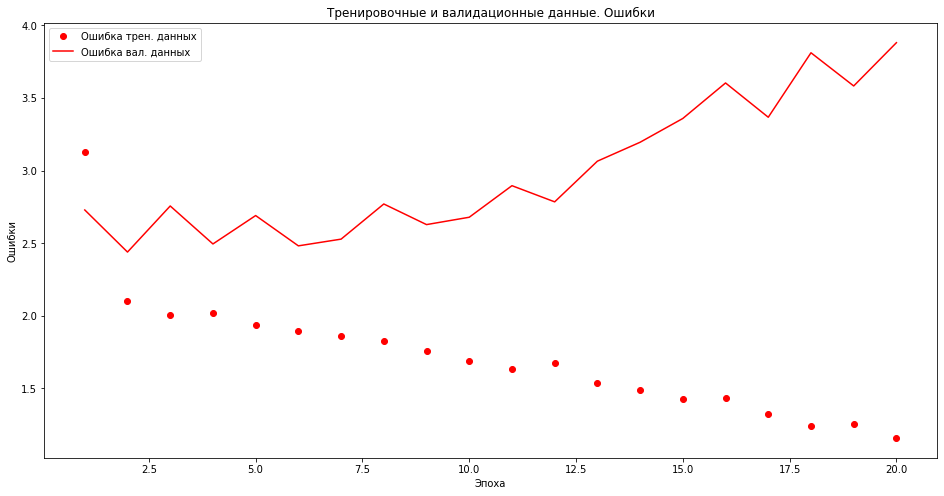

<Figure size 432x288 with 0 Axes>

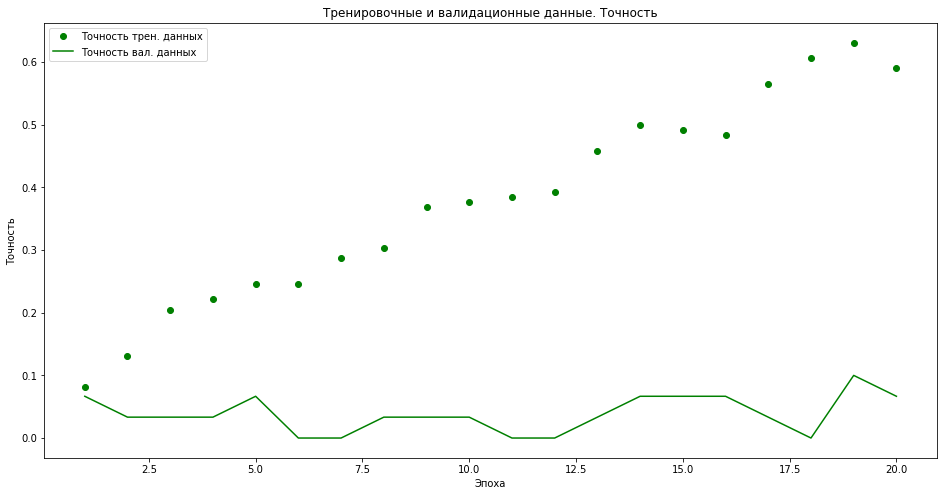

In [14]:
directory = 'emotions' # Путь к фотографиям
batch_size = 8 # Количество данных в одном пакете
image_size = (100,100) # Новое разрешение фотографий
validation_split = 0.2 # Доля данных для проверки нейронной сети
epochs=20 # Количество эпох для нейронной сети

# Создаем датасет для нейронной сети
data(directory, batch_size, image_size, validation_split) 

# Иницилизируем модель
model = kr.models.Sequential()

# Настраиваем входной слой модели нейронной сети
pretrained_model= kr.applications.ResNet50(include_top=False,
                   input_shape=(100,100,3),
                   pooling='avg',classes=8,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

# Настраиваем нейронную сеть
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=kr.optimizers.SGD(lr=0.0001), metrics=['accuracy'])

history = model.fit(  
  training_data,
  validation_data=validation_data,
  epochs=epochs)

visualization(history.history, epochs)

#### Вывод:
Данная модель научилась хорошо классифицировать обучающие данные.
На валидационных данных модель полностью провалилась. Причин может быть несколько, но я склоняюсь к тому, что данных для обучения недостаточно

### Реализация нейронной сети через Pytorch

Для предыдущей модели мы разделили весь датасет случайным образом на обучающие и валидационные данные.
При работе с этой моделью, попробуем разбить датасет другим образом: по фотографиям людей

In [15]:
# Вы можете игнорировать этот блок кода при повторном запуске проекта

# Создадим папку с фото, отсортированными по эмоциям
shutil.rmtree('emotions_torch', ignore_errors = True) # Удаляет директорию, созданную ранее при работе кода
os.mkdir(r'emotions_torch')
os.mkdir(r'emotions_torch\train')
os.mkdir(r'emotions_torch\test')
for emo in emotions:
    os.mkdir(r'emotions_torch\train\{}'.format(emo))
    os.mkdir(r'emotions_torch\test\{}'.format(emo))
    
# Скопируем фотографии в новые папки
for i in os.listdir('images')[1:-5]:
    for emo in emotions:
        shutil.copyfile(r'images\\{}\{}.jpg'.format(i,emo), r'emotions_torch\train\{}\\{}.jpg'.format(emo,i))
for i in os.listdir('images')[-5:]:
    for emo in emotions:
        shutil.copyfile(r'images\\{}\{}.jpg'.format(i,emo), r'emotions_torch\test\{}\\{}.jpg'.format(emo,i))

In [16]:
data_dir = "emotions_torch" # Путь к файлу

In [17]:
# Изменим изображения
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((1280, 720)), # Уменьшаем размерность изображений до 1280х720 пикселя 
        transforms.ToTensor(), # Преобразование изображения в тензор
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Нормализуем изображения
    ]),
    'test': transforms.Compose([
        transforms.Resize((1280, 720)), # Уменьшаем размерность изображений до 1280х720 пикселя 
        transforms.ToTensor(), # Преобразование изображения в тензор
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Нормализуем изображения
    ]),
}

In [18]:
# Функцию для создания датасета
def get_dataset(data_dir, data_transforms ):
    
    # Создание обучающей и тестовой выборки
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                                              for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                                 shuffle=True, num_workers=4)
                                                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    
    # Получим название классов из названий папок
    classes = image_datasets['train'].classes
    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [19]:
# Создание датасета
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Классы: ',  classes)
print('Размер датасета: ',  dataset_sizes)

Классы:  ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
Размер датасета:  {'train': 112, 'test': 40}


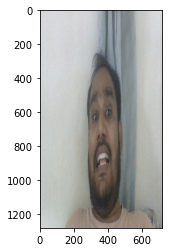

Класс картинки:  Fear


In [20]:
# Функция отображения изображения
def imshow(img):
    img = img / 2+0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Получим случайные изображения
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Отобразим картинку
imshow(torchvision.utils.make_grid(images))
print("Класс картинки:", ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [21]:
# Создадим архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 2)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 12, 3, 2)
        self.fc1 = nn.Linear(2508, 1000)
        self.fc2 = nn.Linear(1000, 550)
        self.fc3 = nn.Linear(550, 200)
        self.fc4 = nn.Linear(200, 90)
        self.fc5 = nn.Linear(90, 8)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
net = Net()

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=2508, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=550, bias=True)
  (fc3): Linear(in_features=550, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=90, bias=True)
  (fc5): Linear(in_features=90, out_features=8, bias=True)
)


In [22]:
# Обучение нейронной сети

criterion = nn.CrossEntropyLoss() # Для нахождения величины потерь
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Настройка оптимизатора
device = torch.device("cpu") # Вычисления будут проходить на процессоре
for epoch in range(11):  # Количество эпох обучения
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # Получение входных данных. Данные имеют вид: [inputs, labels]
        optimizer.zero_grad() # Обнуление параметров градиента
        # Обучение
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Вывод статистики
        running_loss += loss.item()
        if i % 50 == 14:   
            print('[%d, %5d] потери: %.3f' %
                  (epoch + 1, i + 1, running_loss / 15))
            running_loss = 0.0
print('Обучение завершено')

[1,    15] потери: 2.075
[1,    65] потери: 6.953
[2,    15] потери: 2.083
[2,    65] потери: 6.964
[3,    15] потери: 2.076
[3,    65] потери: 6.947
[4,    15] потери: 2.081
[4,    65] потери: 6.932
[5,    15] потери: 2.084
[5,    65] потери: 6.942
[6,    15] потери: 2.072
[6,    65] потери: 6.957
[7,    15] потери: 2.077
[7,    65] потери: 6.943
[8,    15] потери: 2.080
[8,    65] потери: 6.939
[9,    15] потери: 2.076
[9,    65] потери: 6.943
[10,    15] потери: 2.078
[10,    65] потери: 6.930
[11,    15] потери: 2.076
[11,    65] потери: 6.942
Обучение завершено


Ответ нейросети - Disgust, настоящий класс - Happy, дополнительные ответы от нейросети (Anger,Contempt)


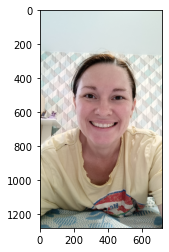

Ответ нейросети - Disgust, настоящий класс - Sad, дополнительные ответы от нейросети (Anger,Contempt)


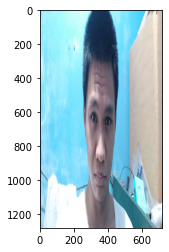

Ответ нейросети - Disgust, настоящий класс - Neutral, дополнительные ответы от нейросети (Anger,Contempt)


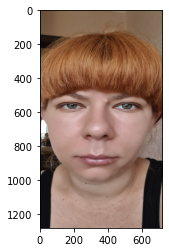

Ответ нейросети - Disgust, настоящий класс - Disgust, дополнительные ответы от нейросети (Anger,Contempt)


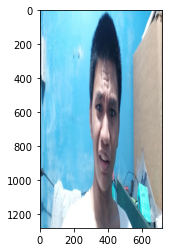

Ответ нейросети - Disgust, настоящий класс - Contempt, дополнительные ответы от нейросети (Anger,Contempt)


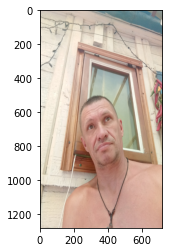

Ответ нейросети - Disgust, настоящий класс - Contempt, дополнительные ответы от нейросети (Anger,Contempt)


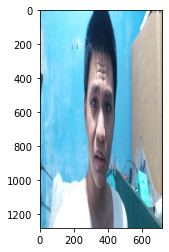

Ответ нейросети - Disgust, настоящий класс - Fear, дополнительные ответы от нейросети (Anger,Contempt)


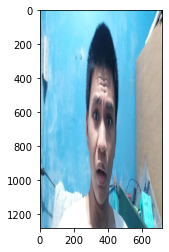

Ответ нейросети - Disgust, настоящий класс - Surprised, дополнительные ответы от нейросети (Anger,Contempt)


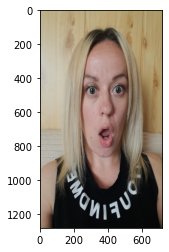

Ответ нейросети - Disgust, настоящий класс - Anger, дополнительные ответы от нейросети (Anger,Contempt)


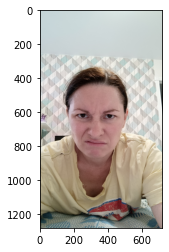

Ответ нейросети - Disgust, настоящий класс - Surprised, дополнительные ответы от нейросети (Anger,Contempt)


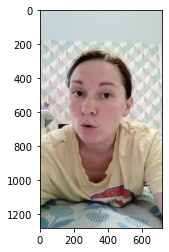

Ответ нейросети - Disgust, настоящий класс - Neutral, дополнительные ответы от нейросети (Anger,Contempt)


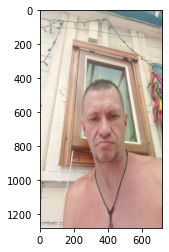

Ответ нейросети - Disgust, настоящий класс - Surprised, дополнительные ответы от нейросети (Anger,Contempt)


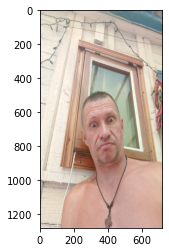

Ответ нейросети - Disgust, настоящий класс - Contempt, дополнительные ответы от нейросети (Anger,Contempt)


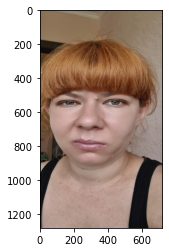

Ответ нейросети - Disgust, настоящий класс - Fear, дополнительные ответы от нейросети (Anger,Contempt)


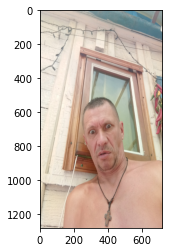

Ответ нейросети - Disgust, настоящий класс - Neutral, дополнительные ответы от нейросети (Anger,Contempt)


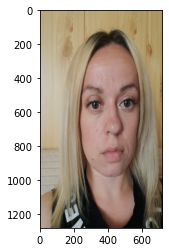

Ответ нейросети - Disgust, настоящий класс - Fear, дополнительные ответы от нейросети (Anger,Contempt)


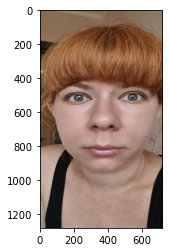

Ответ нейросети - Disgust, настоящий класс - Disgust, дополнительные ответы от нейросети (Anger,Contempt)


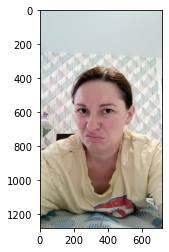

Ответ нейросети - Disgust, настоящий класс - Disgust, дополнительные ответы от нейросети (Anger,Contempt)


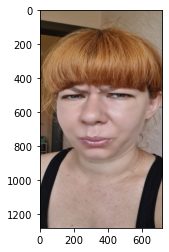

Ответ нейросети - Disgust, настоящий класс - Sad, дополнительные ответы от нейросети (Anger,Contempt)


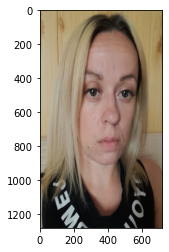

Ответ нейросети - Disgust, настоящий класс - Contempt, дополнительные ответы от нейросети (Anger,Contempt)


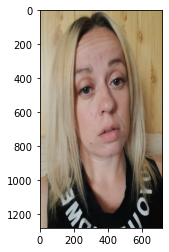

Ответ нейросети - Disgust, настоящий класс - Happy, дополнительные ответы от нейросети (Anger,Contempt)


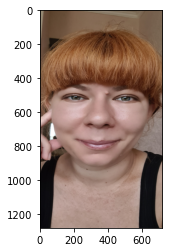

Ответ нейросети - Disgust, настоящий класс - Disgust, дополнительные ответы от нейросети (Anger,Contempt)


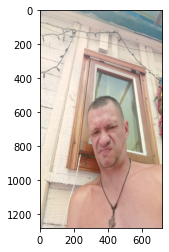

Ответ нейросети - Disgust, настоящий класс - Contempt, дополнительные ответы от нейросети (Anger,Contempt)


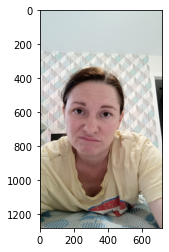

Ответ нейросети - Disgust, настоящий класс - Neutral, дополнительные ответы от нейросети (Anger,Contempt)


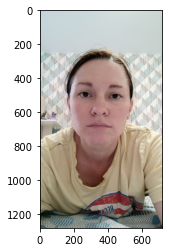

Ответ нейросети - Disgust, настоящий класс - Neutral, дополнительные ответы от нейросети (Anger,Contempt)


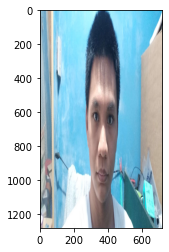

Ответ нейросети - Disgust, настоящий класс - Anger, дополнительные ответы от нейросети (Anger,Contempt)


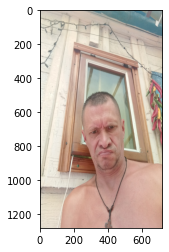

Ответ нейросети - Disgust, настоящий класс - Surprised, дополнительные ответы от нейросети (Anger,Contempt)


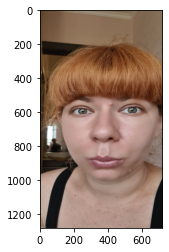

Ответ нейросети - Disgust, настоящий класс - Sad, дополнительные ответы от нейросети (Anger,Contempt)


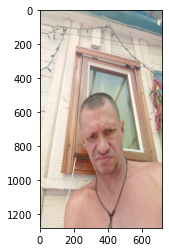

Ответ нейросети - Disgust, настоящий класс - Anger, дополнительные ответы от нейросети (Anger,Contempt)


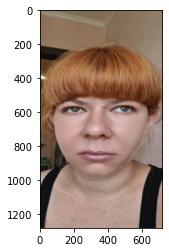

Ответ нейросети - Disgust, настоящий класс - Disgust, дополнительные ответы от нейросети (Anger,Contempt)


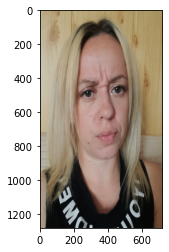

Ответ нейросети - Disgust, настоящий класс - Fear, дополнительные ответы от нейросети (Anger,Contempt)


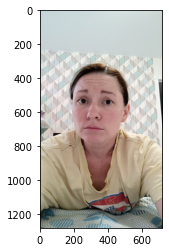

Ответ нейросети - Disgust, настоящий класс - Anger, дополнительные ответы от нейросети (Anger,Contempt)


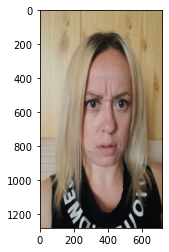

Ответ нейросети - Disgust, настоящий класс - Anger, дополнительные ответы от нейросети (Anger,Contempt)


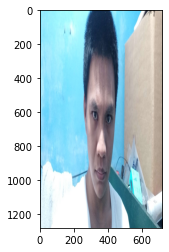

Ответ нейросети - Disgust, настоящий класс - Happy, дополнительные ответы от нейросети (Anger,Contempt)


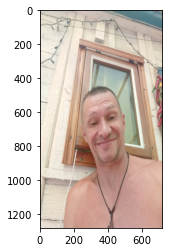

Ответ нейросети - Disgust, настоящий класс - Happy, дополнительные ответы от нейросети (Anger,Contempt)


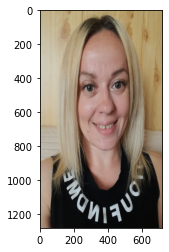

Ответ нейросети - Disgust, настоящий класс - Surprised, дополнительные ответы от нейросети (Anger,Contempt)


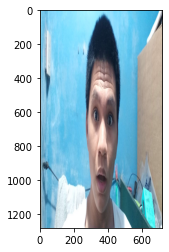

Ответ нейросети - Disgust, настоящий класс - Sad, дополнительные ответы от нейросети (Anger,Contempt)


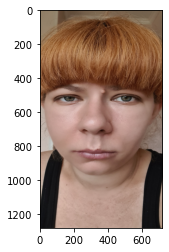

Ответ нейросети - Disgust, настоящий класс - Sad, дополнительные ответы от нейросети (Anger,Contempt)


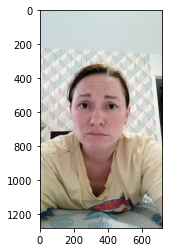

Ответ нейросети - Disgust, настоящий класс - Happy, дополнительные ответы от нейросети (Anger,Contempt)


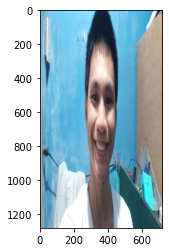

Ответ нейросети - Disgust, настоящий класс - Fear, дополнительные ответы от нейросети (Anger,Contempt)


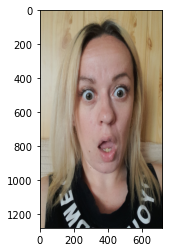

Точность сети на 40 тестовых картинках: 12 %


In [23]:
# Отобразим работу нейронной сети на данных, на которых она обучалась

correct = 0
total = 0
with torch.no_grad(): # Для того, чтобы не считался градиент
    for data in testloader: # Идем по тестовым данным
        images, labels = data # Получаем изображение и метку
        outputs = net(images) # Подаем тестовое изображение на нейронную сеть
        _, predicted = torch.max(outputs.data, 1) # Вычисление предсказанного класса
        
        for printdata in list(zip(predicted,labels,outputs)): # Идем по предсказанным классам
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Ответ нейросети - {0}, настоящий класс - {1}, дополнительные ответы от нейросети ({2},{3})'
                  .format(printclass[0],printclass[1],classes[0], classes [1]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow(torchvision.utils.make_grid(images))
print('Точность сети на', dataset_sizes['test'], 'тестовых картинках: %d %%' % (100 * correct / total))

#### Вывод:
Модель не научилась классифицировать валидационные данные. Вероятная причина: недостаточное количество обучающих данных

## Вывод

1. Были созданы 2 модели нейронных сетей для классификации данных. Первая - сверточная нейронная сеть на основе библиотеки Keras. Вторая - сверточная нейронная сеть на основе библиотеки PyTorch.
2. Ни одна из моделей не смогла научиться хорошо классифицировать изображения. Вероятная причина: недостаточно обучающих данных. Также стоит учитывать, что возможно была реализована неподходящая архитектура, которую следует изменить (количество слоев/нейронов/эпох_обучения и т.д.)
3. Данную работу можно использовать как пример для создания создания собственных нейронных сетей